# EXPERIMENTAL DESIGN FOR CAUSAL EFFECT IDENTIFICATION

We import some useful libraries.

In [1]:
# Import useful libraries
import numpy as np
from ci_test import ci_test
from scipy.io import loadmat
import networkx as nx
from itertools import chain, combinations, permutations
from helpers import *
from collections import deque
from copy import copy
from matplotlib import pyplot as plt
# !pip install pulp
import time


from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

We manually create the toy model on which we are going to test the functions implemented in helpers.

In [2]:
# Defining the nodes
nodes = ['z','t','s','w']

# Initializing both the directed and undirected graph (ADMG)
G_b = nx.Graph()
G_d = nx.DiGraph()

# Adding nodes and edges to the graph
for node in nodes:
    G_b.add_node(node)
    G_d.add_node(node)
G_d.add_edge('z','t')
G_d.add_edge('w','t')
G_d.add_edge('t','s')

G_b.add_edge('z','s')
G_b.add_edge('z','t')
G_b.add_edge('t','w')
G_b.add_edge('w','s')
HHull(G_d, G_b, {'s'})

{'s', 't', 'w', 'z'}

We now define the dictionary containing the costs of intervention and then we run the first proposed solution: the brute force Min Cost Intervention Algorithm. Notice that here we are not using the generalized implementation of such algorithm since S consists of only node node, therefore being included in one single c-components.

In [3]:
# Defining the costs
costs = {'z':2, 'w':2, 't':3, 's':1}

# Running the algorithm and printing the output
A,_ = MinCostIntervention({'s'},G_d, G_b,costs)
A

{'t'}

Since S is a c-component, then the General version should return the same result.

In [4]:
result = GeneralMinCostIntervention({'s'}, G_d, G_b, costs)
result

{'t'}

Since the previous solution scales exponentially in the number of nodes, we now implement and try an heuristic approach which might return a sub-optimal solution.

In [5]:
# Running the heuristic algorithm and printing the output
A = heuristic_algorithm(G_d, G_b, {'s'}, costs)
A

{'t'}

As requested in the project description, we run a sanity check to test the correctness of the functions we have implemented.

In [6]:
#Sanity check
G_d_test = G_d.copy()
for node in A:
    parents = list(G_d.predecessors(node))

    # Remove edges from the parents
    for parent in parents:
        G_d_test.remove_edge(parent, node)
        
HHull(G_d_test,G_b, {'s'})

{'s'}

## Graphs generation (S single node)

Run only if needed, it takes a lot (some hours).

In [ ]:
np.random.seed(42)

n_s = np.arange(10,25,3)

print('#nodes in analysis: ', n_s)

min_cost_time, heuristic_time = [], []

cost_exact_sol, cost_heuristic_sol = [], []

p_directed, p_bidirected = 0.35, 0.25

for n in n_s:
    
    # We create a costs dictionary
    costs = {num:np.random.randint(1,5) for num in range(n)}
    print('DICTIONARY OF COSTS', costs)
    
    # We create the graphs
    G_n_directed = nx.DiGraph()
    G_n_bidirected = nx.Graph()
    
    for node in range(n):
        G_n_directed.add_node(node)
        G_n_bidirected.add_node(node)
        
    for node1 in range(n):
        for node2 in range(n):
            if node1 != node2:
                flag_directed = np.random.random() < p_directed
                flag_bidirected = np.random.random() < p_bidirected
                if flag_directed:
                    G_n_directed.add_edge(node1,node2)
                if flag_bidirected:
                    G_n_bidirected.add_edge(node1,node2)
    
    # We select S
    S = set(np.random.choice(range(n), size=1, replace=False))
    print('The set S is: ', S)
    
    # We save running time of both algos (min cost intervention algorithm)
    start = time.time()
    min_cost_sol = GeneralMinCostIntervention( S, G_n_directed, G_n_bidirected, costs)
    end = time.time()
    min_cost_time.append(end - start)
    cost_e = 0
    for elem in min_cost_sol:
        cost_e += costs[elem]
    print('Cost of exact solution', cost_e)
    cost_exact_sol.append(cost_e)
    
    # We save running time of both algos (heuristic algorithm)
    start = time.time()
    min_cost_sol_heuristic = heuristic_algorithm(G_n_directed, G_n_bidirected, S, costs)
    end = time.time()
    heuristic_time.append(end - start)
    cost_h = 0
    for elem in min_cost_sol_heuristic:
        cost_h += costs[elem]
    print('Cost of heuristic solution', cost_h)
    cost_heuristic_sol.append(cost_h)

    print(min_cost_sol, min_cost_sol_heuristic)
    print('Iteration')

plt.plot(n_s, min_cost_time, '-o', label = 'MinCostIntervention')
plt.plot(n_s, heuristic_time, '-o', label='Heuristic Algorithm')
plt.title('Comparison of running times')
plt.xlabel('number of nodes in the graph')
plt.ylabel('seconds of run')
plt.legend()
plt.show()

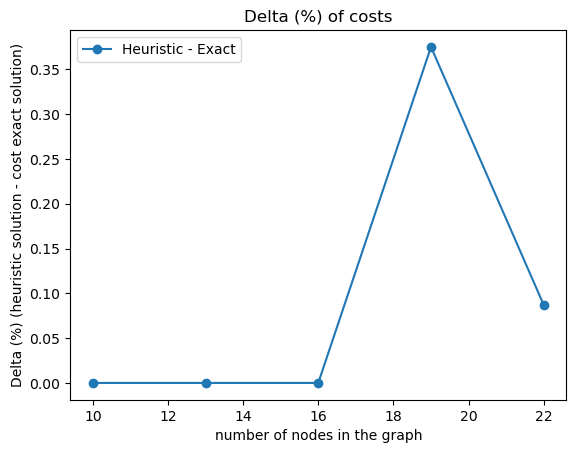

In [16]:
cost_diff = [(heuristic_cost - exact_cost)/exact_cost for heuristic_cost, exact_cost in zip(cost_heuristic_sol, cost_exact_sol)]
plt.plot(n_s, cost_diff, '-o', label = 'Heuristic - Exact')
plt.title('Delta (%) of costs')
plt.xlabel('number of nodes in the graph')
plt.ylabel('Delta (%) (heuristic solution - cost exact solution)')
plt.legend()
plt.savefig('costs.png')
plt.show()

## Graph where suboptimal solution is found

In [7]:
cost_list = [2,2,3,2,3,1,3,1,3,4,4,2,3,3,1,2,3,2,4]

DICTIONARY OF COSTS {0: 2, 1: 2, 2: 3, 3: 2, 4: 3, 5: 1, 6: 3, 7: 1, 8: 3, 9: 4, 10: 4, 11: 2, 12: 3, 13: 3, 14: 1, 15: 2, 16: 3, 17: 2, 18: 4}
The set S is:  {3}
Cost of exact solution 10
Cost of heuristic solution 11
{0, 10, 4, 5} {5, 8, 12, 13, 14}
Iteration


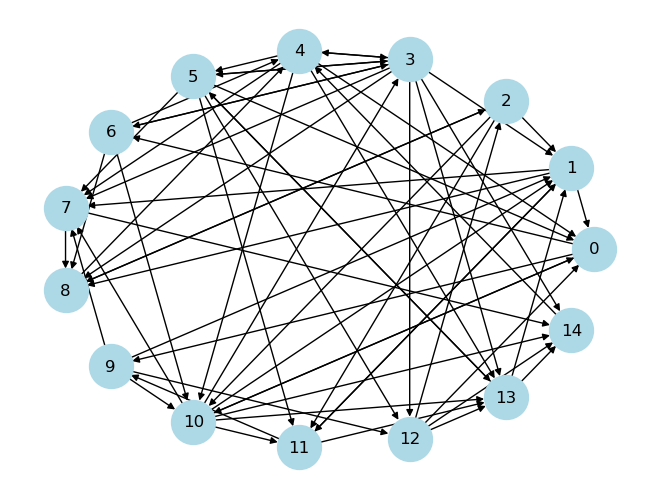

In [11]:
np.random.seed(30)
n = 15

p_directed, p_bidirected = 0.30, 0.20

# We create a costs dictionary
costs = {i:cost_list[i] for i in range(len(cost_list))}
print('DICTIONARY OF COSTS', costs)

# We create the graphs
G_n_directed = nx.DiGraph()
G_n_bidirected = nx.Graph()

for node in range(n):
    G_n_directed.add_node(node)
    G_n_bidirected.add_node(node)

for node1 in range(n):
    for node2 in range(n):
        if node1 != node2:
            flag_directed = np.random.random() < p_directed
            flag_bidirected = np.random.random() < p_bidirected
            if flag_directed:
                G_n_directed.add_edge(node1,node2)
            if flag_bidirected:
                G_n_bidirected.add_edge(node1,node2)

# We select S
S = {3}
print('The set S is: ', S)

min_cost_sol = GeneralMinCostIntervention( S, G_n_directed, G_n_bidirected, costs)

cost_e = 0
for elem in min_cost_sol:
    cost_e += costs[elem]
print('Cost of exact solution', cost_e)

min_cost_sol_heuristic = heuristic_algorithm(G_n_directed, G_n_bidirected, S, costs)

cost_h = 0
for elem in min_cost_sol_heuristic:
    cost_h += costs[elem]
print('Cost of heuristic solution', cost_h)

print(min_cost_sol, min_cost_sol_heuristic)
print('Iteration')

pos = nx.circular_layout(G_n_directed)
nx.draw(G_n_directed, pos, with_labels=True, node_color='lightblue', node_size=1000, font_size=12)
plt.show()

## LINEAR PROGRAMMING

In [13]:
result = LP_MinCostIntervention({'s'}, G_d, G_b, costs)
result

{'t'}